# Lab 8: 朴素贝叶斯 - 预测贷款违约

credit_policy： 如果客户符合信贷标准为1，否则为0。

purpose： 贷款的用途。

int_rate： 贷款的利率（风险较高的借款人分配更高的利率）。

installment： 如果贷款获得批准，借款人每月应还的分期付款。

log_annual_inc： 借款人报告的年收入的自然对数。

dti： 借款人的债务收入比（债务金额除以年收入）。

fico： 借款人的FICO信用评分。

days_with_cr_line： 借款人拥有信用额度的天数。

revol_bal： 借款人的循环余额（信用卡账单周期结束时未支付的金额）。

revol_util： 借款人的循环额度使用率（使用的信用额度相对于总信用额度的比例）。

inq_last_6mths： 借款人过去6个月内向债权人查询的次数。

delinq_2yrs： 借款人在过去2年中逾期30天以上的次数。

pub_rec： 借款人的不良公共记录数量。

not_fully_paid： 如果贷款未完全偿还为1，否则为0。

## 1. 导入贷款数据

In [1]:
import os
import sys
import pandas as pd

path = os.path.dirname(os.getcwd())
sys.path.append(path)

from common.filesio import FilesIO
data = pd.read_csv(FilesIO.getLectureData('loan_data.csv'))
data.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1428 entries, 0 to 1427
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      1428 non-null   int64  
 1   purpose            1428 non-null   object 
 2   int.rate           1428 non-null   float64
 3   installment        1428 non-null   float64
 4   log.annual.inc     1428 non-null   float64
 5   dti                1428 non-null   float64
 6   fico               1428 non-null   int64  
 7   days.with.cr.line  1428 non-null   float64
 8   revol.bal          1428 non-null   int64  
 9   revol.util         1428 non-null   float64
 10  inq.last.6mths     1428 non-null   int64  
 11  delinq.2yrs        1428 non-null   int64  
 12  pub.rec            1428 non-null   int64  
 13  not.fully.paid     1428 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 156.3+ KB


## 2. 探索性分析

In [3]:
data.describe()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
count,1428.0,1428.000000,1428.000000,1428.000000,1428.000000,1428.000000,1428.000000,1428.000000,1428.000000,1428.000000,1428.000000,1428.000000,1428.000000
mean,1.0,0.108147,276.029727,10.901808,11.581947,712.042017,4505.133637,13555.452381,43.569748,1.018207,0.193978,0.075630,0.163866
std,0.0,0.020213,187.915367,0.585102,6.716894,37.255134,2380.179718,17150.838011,28.579624,1.198436,0.557341,0.267135,0.370283
min,1.0,0.060000,15.690000,8.517193,0.000000,627.000000,1110.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,0.094500,154.282500,10.524064,6.015000,682.000000,2729.729167,3112.750000,18.675000,0.000000,0.000000,0.000000,0.000000
50%,1.0,0.107100,228.220000,10.878047,11.370000,707.000000,4169.979166,8290.500000,42.550000,1.000000,0.000000,0.000000,0.000000
75%,1.0,0.121700,338.100000,11.272042,17.002500,737.000000,5639.968750,17221.250000,66.225000,2.000000,0.000000,0.000000,0.000000
max,1.0,0.183600,895.560000,14.528354,29.420000,822.000000,16259.041670,148829.000000,99.400000,8.000000,5.000000,2.000000,1.000000


### 2.1 输出Y是否平衡

In [4]:
count = data["not.fully.paid"].value_counts()
count

0    1194
1     234
Name: not.fully.paid, dtype: int64

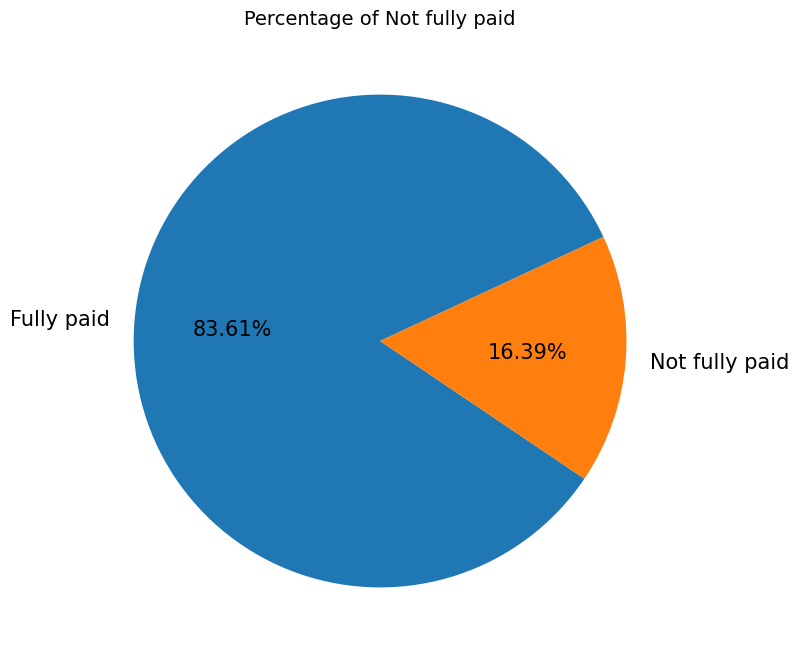

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))

#colors = ["#FA5858", "#64FE2E"]
labels = "Fully paid", "Not fully paid"

count = data["not.fully.paid"].value_counts()

# Change label fontsize
textprops = {"fontsize":15}

plt.pie(count,  autopct='%1.2f%%', labels=labels,  startangle=25, textprops =textprops)

plt.title("Percentage of Not fully paid", fontsize=14)
plt.show()

### 2.2 查看特征在每类下是否服从高斯分布

### 贷款利率： 基本服从高斯分布

array([<AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'1'}>], dtype=object)

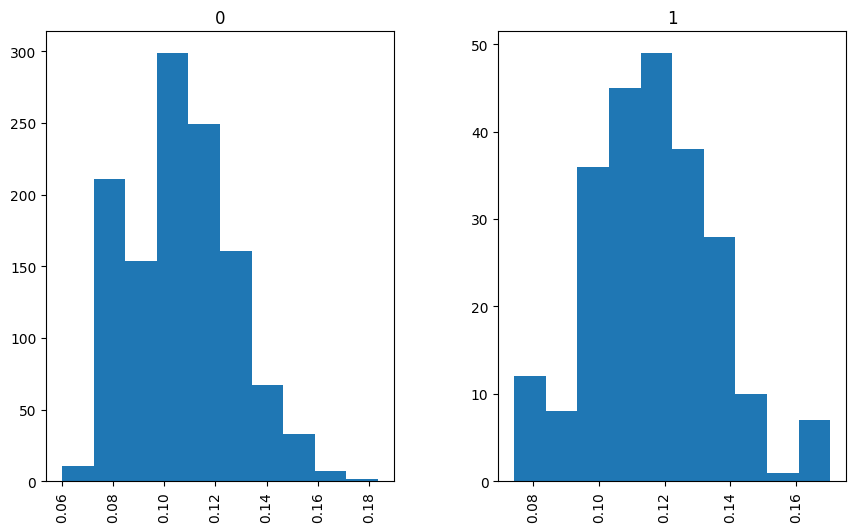

In [6]:
data.hist('int.rate', by = "not.fully.paid", figsize=(10,6))

### 借款人每月应还的分期付款： 右偏态分布

array([<AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'1'}>], dtype=object)

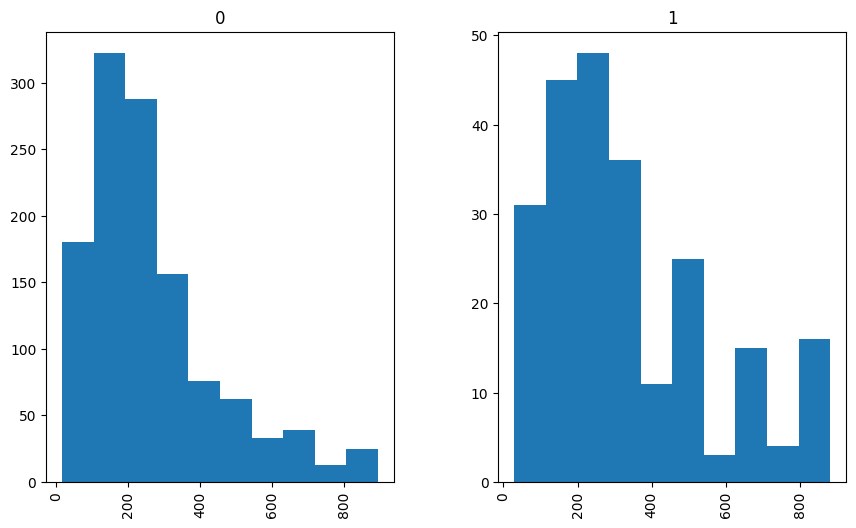

In [7]:
data.hist('installment', by = "not.fully.paid", figsize=(10,6))

### 借款人报告的年收入的自然对数： 基本正态分布

array([<AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'1'}>], dtype=object)

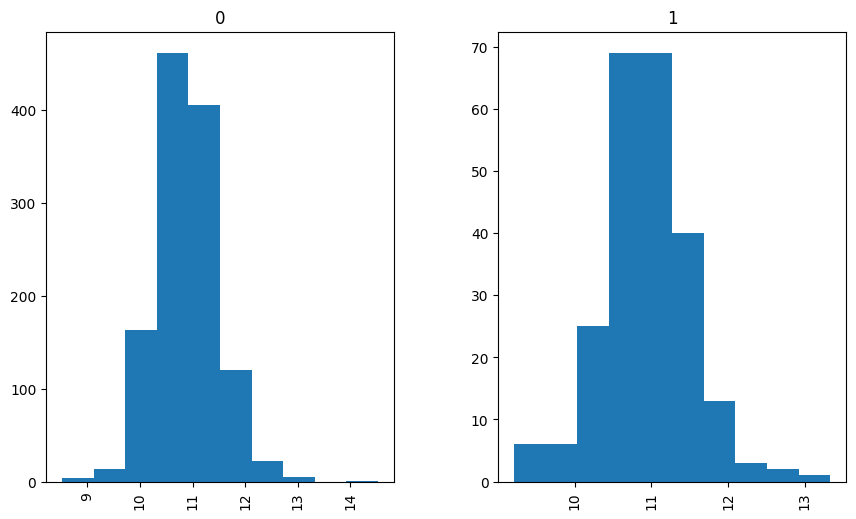

In [8]:
data.hist('log.annual.inc', by = "not.fully.paid", figsize=(10,6))

### 借款人的债务收入比：不太正态

array([<AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'1'}>], dtype=object)

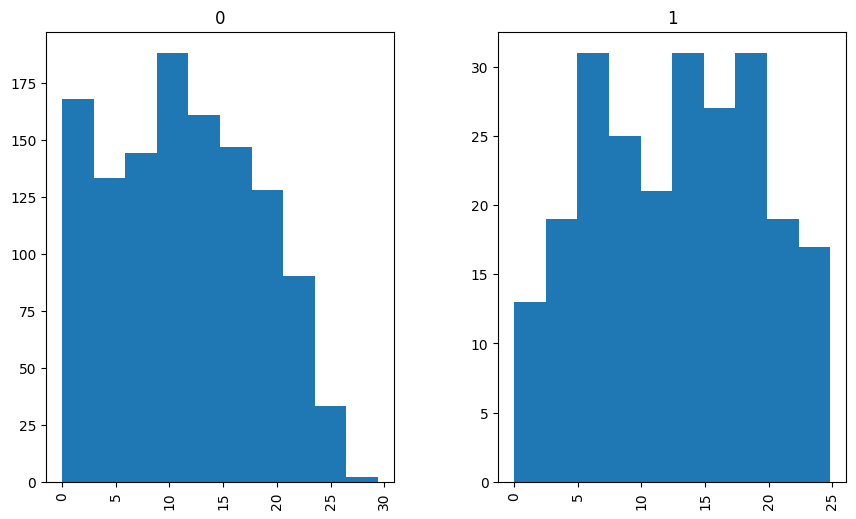

In [9]:
data.hist('dti', by = "not.fully.paid", figsize=(10,6))

### 借款人的FICO信用评分：非正态

array([<AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'1'}>], dtype=object)

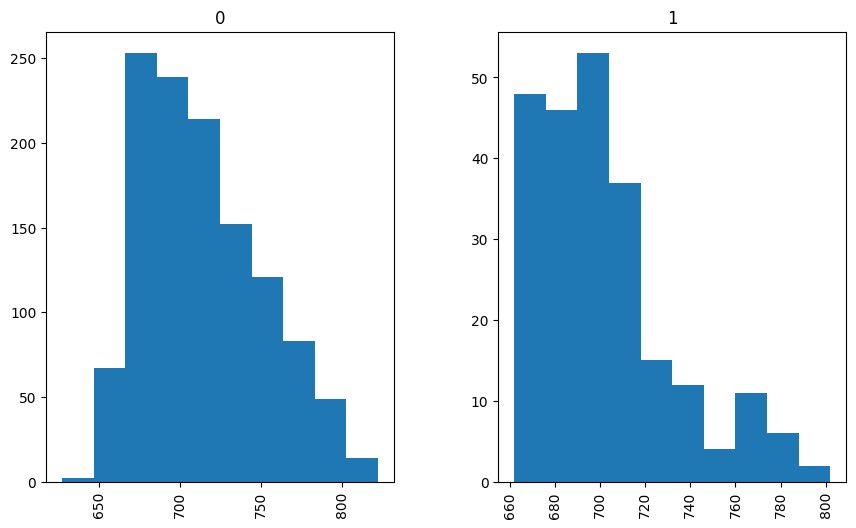

In [10]:
data.hist('fico', by = "not.fully.paid", figsize=(10,6))

### 借款人拥有信用额度的天数：非正态

array([<AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'1'}>], dtype=object)

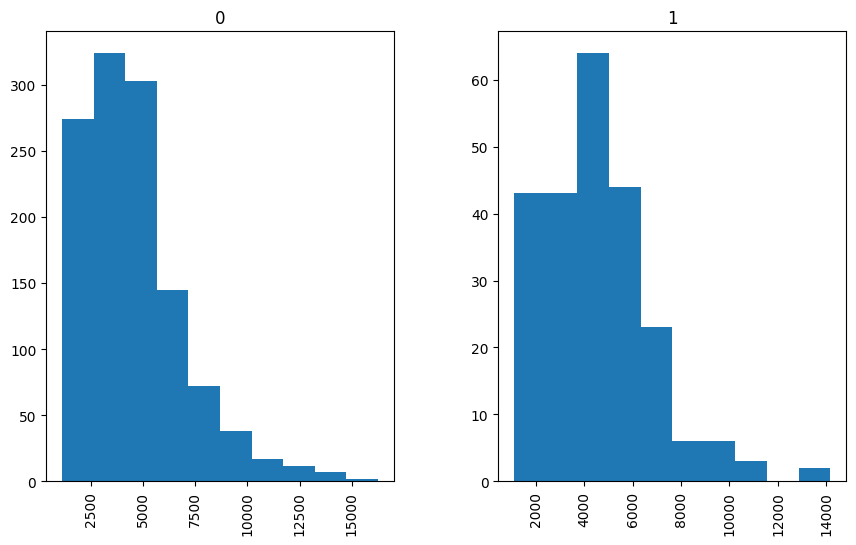

In [11]:
data.hist('days.with.cr.line', by = "not.fully.paid", figsize=(10,6))

### 借款人的循环余额（信用卡账单周期结束时未支付的金额）：非正态

array([<AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'1'}>], dtype=object)

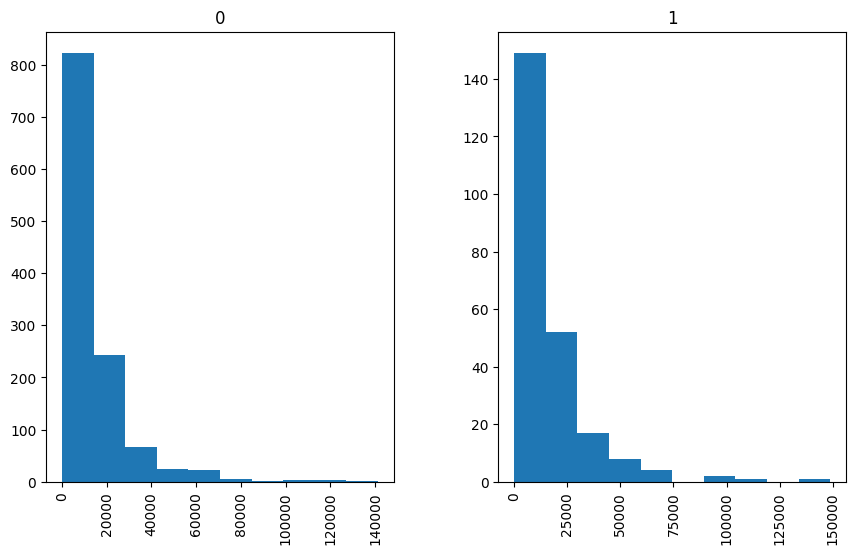

In [12]:
data.hist('revol.bal', by = "not.fully.paid", figsize=(10,6))

### 借款人的循环额度使用率：非正态 

array([<AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'1'}>], dtype=object)

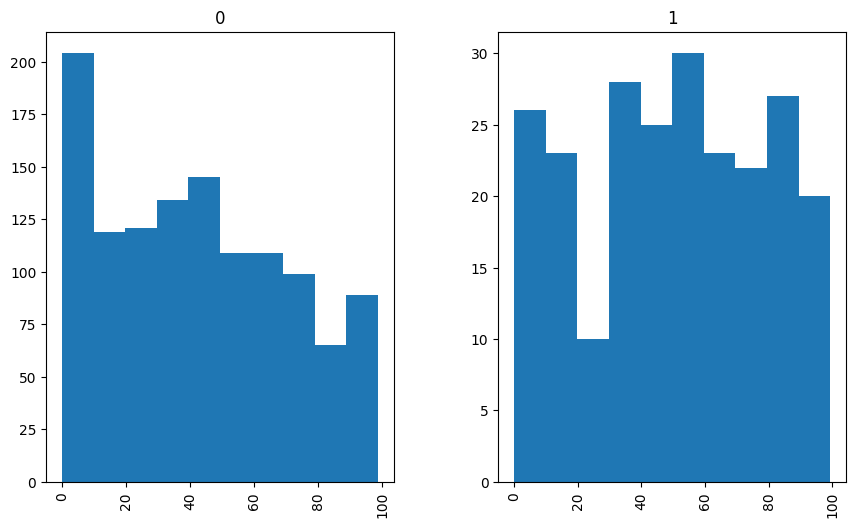

In [13]:
data.hist('revol.util', by = "not.fully.paid", figsize=(10,6))

### 借款人过去6个月内向债权人查询的次数：非正态

array([<AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'1'}>], dtype=object)

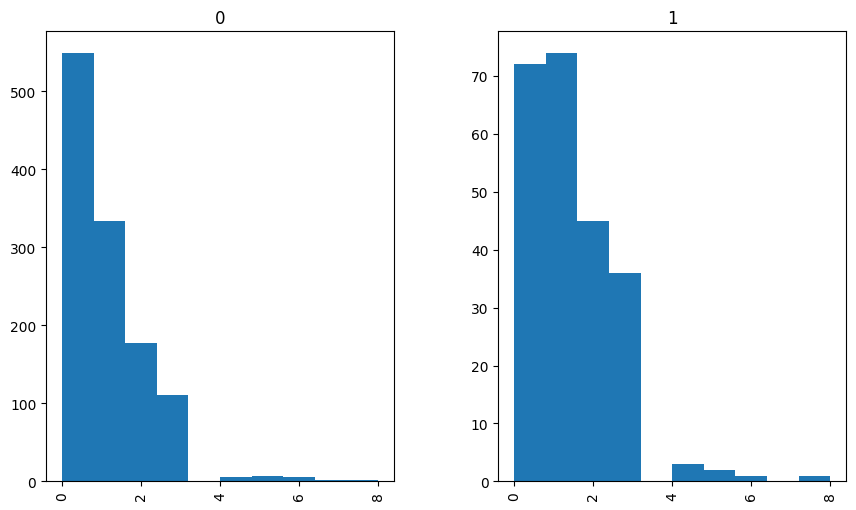

In [14]:
data.hist('inq.last.6mths', by = "not.fully.paid", figsize=(10,6))

### 借款人在过去2年中逾期30天以上的次数：非正态

array([<AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'1'}>], dtype=object)

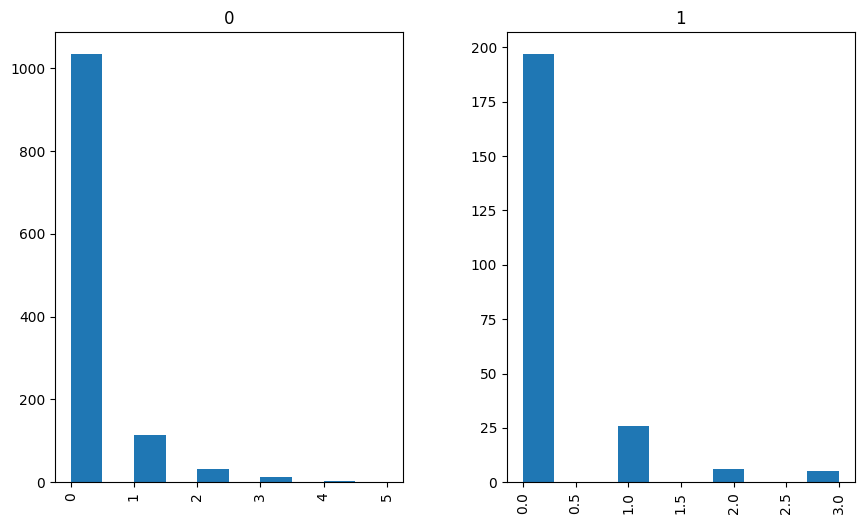

In [15]:
data.hist('delinq.2yrs', by = "not.fully.paid", figsize=(10,6))

### 借款人的不良公共记录数量：非正态

array([<AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'1'}>], dtype=object)

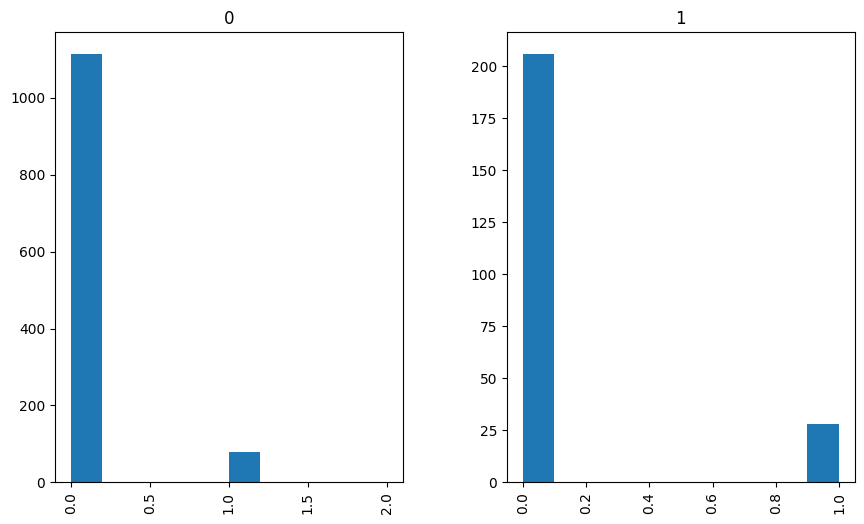

In [16]:
data.hist('pub.rec', by = "not.fully.paid", figsize=(10,6))

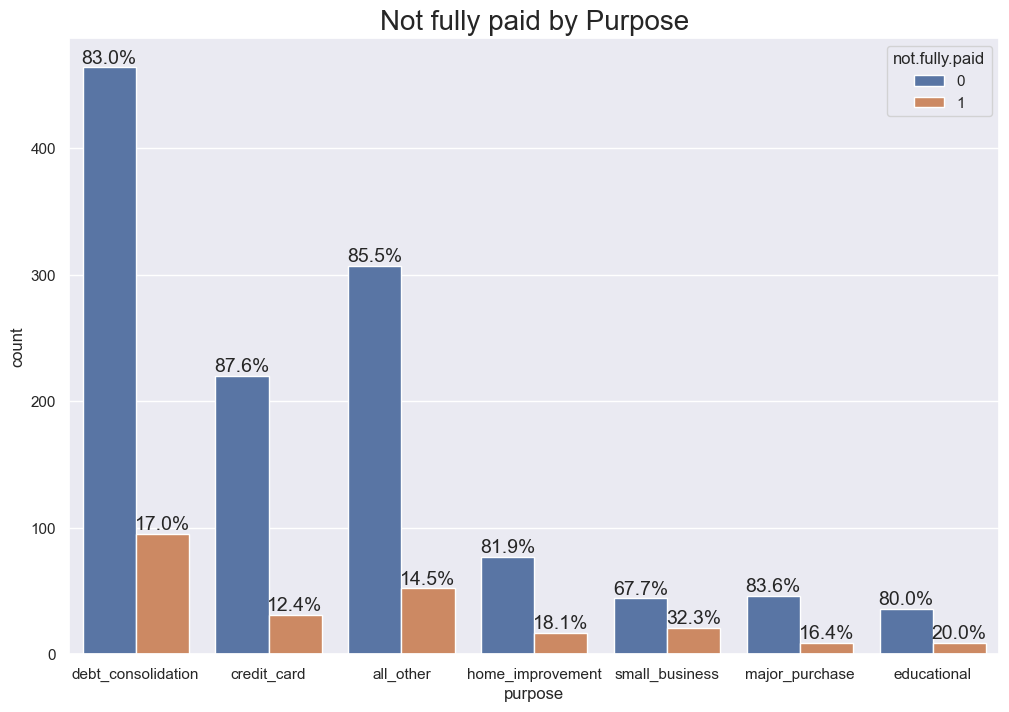

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

## 定义函数percentage_above_bar_relative_to_xgroup， 使得流失百分比显示在条形上方
# 在matplotlib和seaborn中，子地块称为“ax”。seaborn条形图中的条形图是有组织的，首先是属于第一个色调值的所有条形图，然后是第二个，以此类推。
def percentage_above_bar_relative_to_xgroup(ax):
    all_heights = [[p.get_height() for p in bars] for bars in ax.containers]
    for bars in ax.containers:
        for i, p in enumerate(bars):
            total = sum(xgroup[i] for xgroup in all_heights)
            percentage = f'{(100 * p.get_height() / total) :.1f}%'
            ax.annotate(percentage, (p.get_x() + p.get_width() / 2, p.get_height()), size=14, ha='center', va='bottom')
            

sns.set(rc={'figure.figsize':(12,8)})

#total = data["gender"].value_counts()
ax = sns.countplot(data=data,x='purpose',hue='not.fully.paid')
percentage_above_bar_relative_to_xgroup(ax)

# 设置图片标题
plt.title('Not fully paid by Purpose', fontsize=20)

    
plt.show()

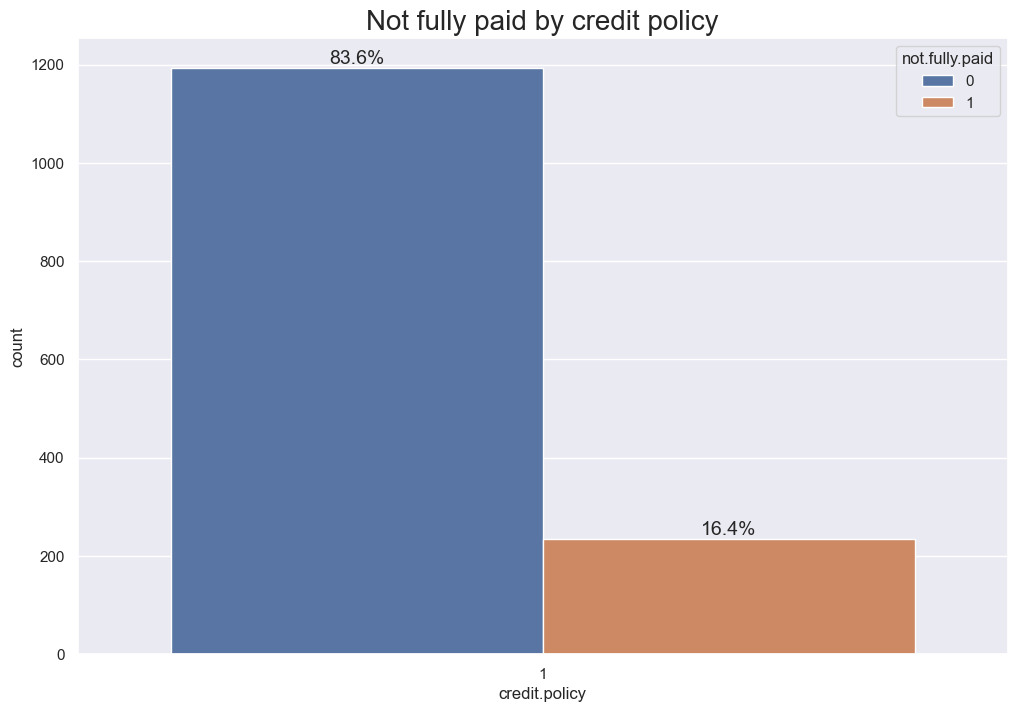

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

## 定义函数percentage_above_bar_relative_to_xgroup， 使得流失百分比显示在条形上方
# 在matplotlib和seaborn中，子地块称为“ax”。seaborn条形图中的条形图是有组织的，首先是属于第一个色调值的所有条形图，然后是第二个，以此类推。
def percentage_above_bar_relative_to_xgroup(ax):
    all_heights = [[p.get_height() for p in bars] for bars in ax.containers]
    for bars in ax.containers:
        for i, p in enumerate(bars):
            total = sum(xgroup[i] for xgroup in all_heights)
            percentage = f'{(100 * p.get_height() / total) :.1f}%'
            ax.annotate(percentage, (p.get_x() + p.get_width() / 2, p.get_height()), size=14, ha='center', va='bottom')
            

sns.set(rc={'figure.figsize':(12,8)})

#total = data["gender"].value_counts()
ax = sns.countplot(data=data,x='credit.policy',hue='not.fully.paid')
percentage_above_bar_relative_to_xgroup(ax)

# 设置图片标题
plt.title('Not fully paid by credit policy', fontsize=20)

    
plt.show()

### 所有客户都符合信贷标准credit.policy=1，不能作为特征

## 3. 设定输出Y和特征X

In [19]:
X = data.drop(['not.fully.paid','credit.policy'], axis=1)
y = data['not.fully.paid']

In [20]:
X.head()

,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec
0,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0
1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0
2,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0
3,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0
4,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0


In [21]:
X = pd.get_dummies(X, drop_first = True)

In [22]:
X.head()

,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
0,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0,1,0,0,0,0
1,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,1,0,0,0,0,0
2,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0,1,0,0,0,0
3,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0,1,0,0,0,0
4,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,1,0,0,0,0,0


## 4. 构建训练集、测试集

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=125)

## 5. 高斯朴素贝叶斯

### 假设：所有特征在每类Y下都服从正态分布,且特征条件独立

### 使用GaussianNB函数
https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html

GaussianNB(*, priors=None, var_smoothing=1e-09)



#### 主要参数：

priors： 类别的先验概率。默认值为None
该参数设置为None.

var_smoothing: 将所有特征的最大方差的一部分添加到方差以保证计算的稳定性。小数, 默认值=1e-9


#### 主要属性：

class_prior_：形状为(n_classes,)，表示每个类别的先验概率。

theta_：形状为(n_classes, n_features)，表示每个类别下每个特征的均值。


### 5.1 加载高斯朴素贝叶斯模型

In [24]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()

### 5.2 在训练集上训练模型

In [25]:
model.fit(X_train, y_train)

GaussianNB()

#### 每个类别的先验概率

In [26]:
model.class_prior_

array([0.83368201, 0.16631799])

#### 每个类别下每个特征的均值

In [27]:
model.theta_

array([[1.06219448e-01, 2.65265408e+02, 1.09078122e+01, 1.12793476e+01,
        7.15506901e+02, 4.56819678e+03, 1.32973952e+04, 4.21370138e+01,
        9.56085320e-01, 1.71894605e-01, 5.89711418e-02, 1.83186951e-01,
        3.93977415e-01, 2.76035132e-02, 6.39899624e-02, 3.51317440e-02,
        4.51693852e-02],
       [1.16847799e-01, 3.45281635e+02, 1.09944846e+01, 1.24247799e+01,
        6.99861635e+02, 4.59512919e+03, 1.60880943e+04, 4.98213836e+01,
        1.30817610e+00, 2.26415094e-01, 1.19496855e-01, 1.44654088e-01,
        3.77358491e-01, 3.14465409e-02, 6.28930818e-02, 3.14465409e-02,
        1.00628931e-01]])

In [28]:
coef0 = model.theta_[0]
coef1 = model.theta_[1]

theta = {'theta y=0': coef0, 'theta y=1': coef1}

pd.DataFrame(theta, index = X.columns)

,theta y=0,theta y=1
int.rate,0.106219,0.116848
installment,265.265408,345.281635
log.annual.inc,10.907812,10.994485
dti,11.279348,12.424780
fico,715.506901,699.861635
days.with.cr.line,4568.196780,4595.129193
revol.bal,13297.395232,16088.094340
revol.util,42.137014,49.821384
inq.last.6mths,0.956085,1.308176
delinq.2yrs,0.171895,0.226415


### 更容易发生贷款违约的客户: 
贷款利率(int.rate)更高，债务收入比(dti)更高，FICO信用评分更低
借款人的循环余额(revol_bal)更高，

借款人过去6个月内向债权人查询的次数(inq_last_6mths)更多，在过去2年中逾期30天以上的次数(delinq_2yrs)更多, 借款人的不良公共记录数量(pub.rec)更多，

贷款的用途为小型企业(purpose_small_business)

### 5.3 在测试集上做预测

#### 预测类别： 用predict

In [29]:
# 在测试集上做预测
y_pred = model.predict(X_test)

y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,

In [30]:
y_pred_prob = model.predict_proba(X_test)
y_pred_prob

array([[8.46419890e-01, 1.53580110e-01],
       [9.36383630e-01, 6.36163701e-02],
       [8.86779146e-01, 1.13220854e-01],
       [8.26112351e-01, 1.73887649e-01],
       [9.03144394e-01, 9.68556057e-02],
       [8.76415720e-01, 1.23584280e-01],
       [9.17539828e-01, 8.24601716e-02],
       [8.43185534e-01, 1.56814466e-01],
       [9.54872059e-01, 4.51279405e-02],
       [8.71798564e-01, 1.28201436e-01],
       [8.45169285e-01, 1.54830715e-01],
       [8.85512730e-01, 1.14487270e-01],
       [8.16549448e-01, 1.83450552e-01],
       [9.19950545e-01, 8.00494554e-02],
       [1.60906007e-01, 8.39093993e-01],
       [9.71191894e-01, 2.88081062e-02],
       [9.79686108e-01, 2.03138921e-02],
       [7.46224237e-01, 2.53775763e-01],
       [4.66023315e-01, 5.33976685e-01],
       [9.08861600e-01, 9.11383996e-02],
       [8.14584451e-01, 1.85415549e-01],
       [9.01017469e-01, 9.89825308e-02],
       [8.92203544e-01, 1.07796456e-01],
       [6.87102437e-01, 3.12897563e-01],
       [4.819774

## 6. 评价模型

### 6.1 正确率

In [31]:
test_accuracy = model.score(X_test, y_test)
print("Accuracy", round(test_accuracy,3))

Accuracy 0.792


### 6.2 精确率(precision), 召回率(recall), F1值

In [32]:
from sklearn import metrics
test_precision = metrics.precision_score(y_test, y_pred)
print("Precision", round(test_precision,3))

test_recall = metrics.recall_score(y_test, y_pred)
print("Recall:", round(test_recall,3))

test_f1 = metrics.f1_score(y_test, y_pred)
print("test_f1:", round(test_f1,3))

Precision 0.171
Recall: 0.08
test_f1: 0.109


### 6.3 混淆矩阵

In [33]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[368,  29],
       [ 69,   6]], dtype=int64)

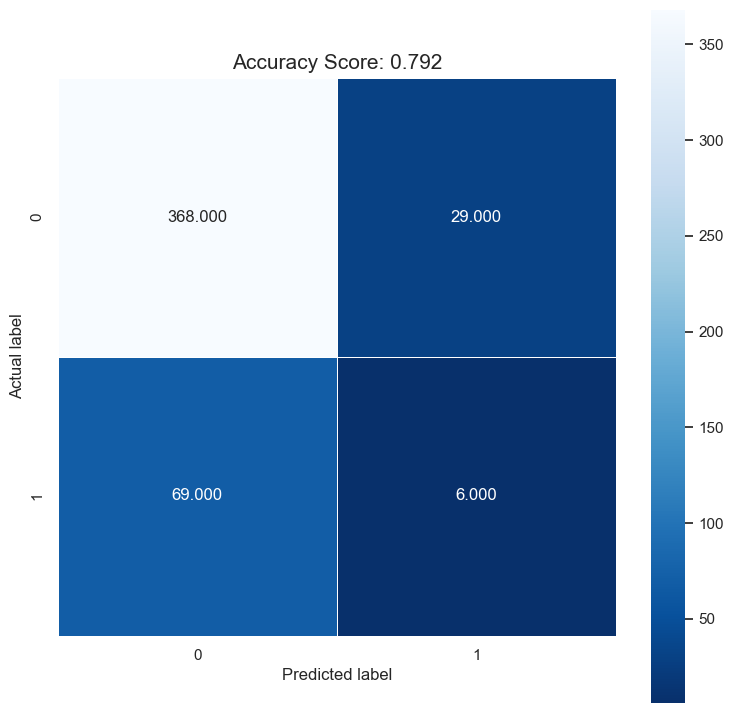

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(9,9))
sns.heatmap(cnf_matrix, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(round(test_accuracy,3))
plt.title(all_sample_title, size = 15);

### 6.4 ROC和AUC

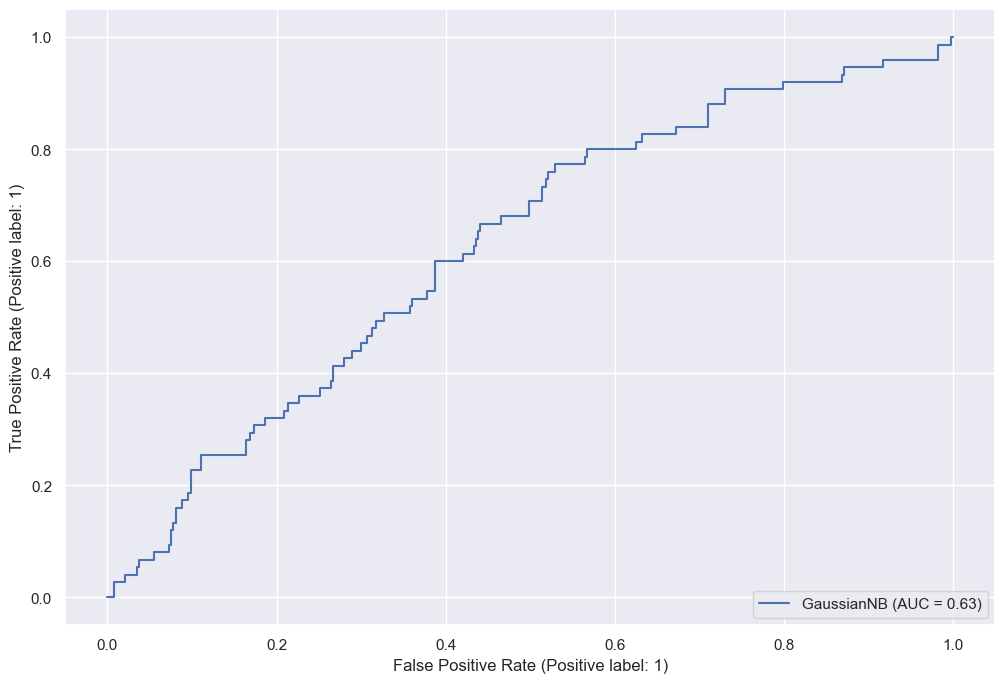

In [35]:
metrics.RocCurveDisplay.from_estimator(model, X_test, y_test) 
plt.show()

## 7. 改变判断Y类别的概率临界值

将临界值从0.5改为0.12

In [36]:
y_pred = (y_pred_prob[:,1]>0.12)*1 

In [37]:
from sklearn import metrics
test_accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy", round(test_accuracy,3))

test_precision = metrics.precision_score(y_test, y_pred)
print("Precision", round(test_precision,3))

test_recall = metrics.recall_score(y_test, y_pred)
print("Recall:", round(test_recall,3))

test_f1 = metrics.f1_score(y_test, y_pred)
print("test_f1:", round(test_f1,3))

Accuracy 0.553
Precision 0.214
Recall: 0.68
test_f1: 0.326


In [38]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[210, 187],
       [ 24,  51]], dtype=int64)

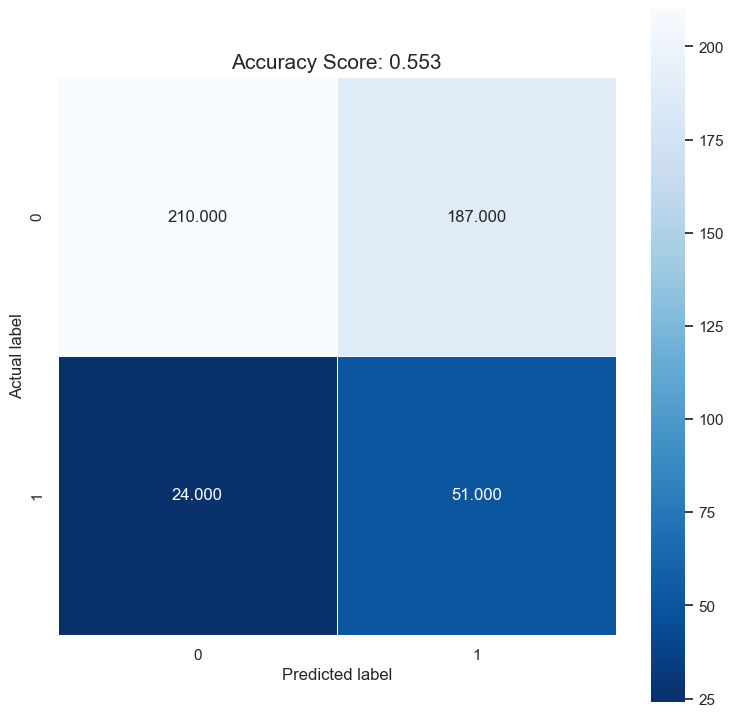

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(9,9))
sns.heatmap(cnf_matrix, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(round(test_accuracy,3))
plt.title(all_sample_title, size = 15);